# Maximum speed plot

## Base imports and functions

In [1]:
from reader import Reader
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime
from datetime import date as date_creator
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from numba import njit
import pandas as pd
import os
from numba import jit
from tqdm import tqdm
from numba import njit

%matplotlib inline

C:\Users\barroisl\AppData\Local\Temp\ipykernel_14248\268809138.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def smooth(x,window_len=11,window='hanning'):
        if x.ndim != 1:
                raise ValueError("smooth only accepts 1 dimension arrays.")
        if x.size < window_len:
                print(x.size)
                raise ValueError("Input vector needs to be bigger than window size.")
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]
    
def get_date_time_dif(start_time,stop_time):
    date = date_creator(1, 1, 1)
    datetime1 = datetime.combine(date, start_time)
    datetime2 = datetime.combine(date, stop_time)
    time_elapsed = datetime1 - datetime2
    return time_elapsed.total_seconds()
def compute_dist(lat1,lon1,lat2,lon2,rad=True):
    if not(rad):
        lat1 = radians(lat1)
        lon1 = radians(lon1)
        lat2 = radians(lat2)
        lon2 = radians(lon2)
    # approximate radius of earth in m
    R = 6373_000.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c
def remove_zero_from_alti(alti):
    if alti[0] < 10 :
        alti[0] = alti[1]
    if alti[-1] < 10 :
        alti[-1] = alti[-2]
    for i,alt in enumerate(alti):
        if alt < 10 :
            if i >= len(alti)-1 :
                alti[i] = (alti[i-1]+alti[i])/2
            else :  
                alti[i] = (alti[i-1]+alti[i+1])/2
    return alti

def read_igc(file):
    with open(file, 'r') as f:
        parsed_igc_file = Reader().read(f)
    # print('igc_file created')
    previous_lat = 0
    previous_lon = 0
    
    all_lon = np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_lat = np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_speed=np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_vz=np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_alti=np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_time=[0 for _ in range(len(parsed_igc_file['fix_records'][1]))]

    for i,record in enumerate(parsed_igc_file['fix_records'][1]):
        record['time'] = record['time'].replace(hour=record['time'].hour + 1)
        all_lat[i] = record['lat']
        all_lon[i] = record['lon']
        if previous_lon ==0 :
            previous_lat = record['lat']
            previous_lon = record['lon']
            previous_datetime = record['time']
            previous_alt_gps = record['gps_alt']
            # previous_alt_baro = record['pressure_alt']
            all_time[i] = record['time']
        else :
            dxy = abs(compute_dist(previous_lat,previous_lon,record['lat'],record['lon'],rad=False))
            # dz = previous_alt_baro-record['pressure_alt']
            dz = previous_alt_gps-record['gps_alt']
            dt = get_date_time_dif(record['time'],previous_datetime)
            # if dt>2 : print('dtttttt>2 ',dt)
            if dt>0 :
                all_speed[i] = min(100,dxy/dt*3.6)
                all_vz[i] = dz/dt
            all_alti[i] = record['gps_alt']
            all_time[i] = record['time']
            
            previous_lat = record['lat']
            previous_lon = record['lon']
            previous_datetime = record['time']
            previous_alt_gps = record['gps_alt']
            # previous_alt_baro = record['pressure_alt']

            # if previous_datetime.hour>10 :
            #     all_speed = all_speed[:i]
            #     all_vz = all_vz[:i]
            #     all_alti = all_alti[:i]
            #     break
#    return all_lon,all_lat,all_speed,all_vz,remove_zero_from_alti(all_alti),all_time
    return all_lon,all_lat,all_alti,all_time

def reshape_array(arr,time_vid):
    nb_img_by_sec = 24
    
    t_true = np.linspace(time_vid[0], time_vid[-1], num=len(time_vid), endpoint=True)
    t_inter = np.linspace(time_vid[0], time_vid[-1], num=int(len(time_vid)*nb_img_by_sec/speed_acc), endpoint=True)
    f = interp1d(t_true, arr, kind='cubic')

    return f(t_inter)

def smooth_igc_output(liste):
    liste[0] = liste[1]
    smoothed = smooth(liste,50,'hanning')
    return smoothed

def plot_smooth_non_smooth(smooth,non_smooth):
    plt.figure(figsize=(18,9))
    plt.plot(non_smooth)
    plt.plot(smooth)
    plt.show()

def get_last_date_of_all_raw_file(path_raw_file):
    delta_time_writing = 20
    all_ending_time = []
    for file in os.listdir(path_raw_file):
        if "_11_" in file :
            time_end = os.path.getmtime(path_raw_file+'\\'+file)
            all_ending_time.append(datetime.fromtimestamp(time_end-delta_time_writing).time())
    return all_ending_time

def convert_time_to_sec(all_time):
    for i in range(len(all_time)):
        all_time[i] = all_time[i].hour*3600 + all_time[i].minute*60 + all_time[i].second
    return np.array(all_time,dtype=np.float32)

In [3]:
from os import listdir
from os.path import isfile, join
path = 'C:/Users/barroisl/Documents/Stage_Léo/Vols/IGC_20-08-2023/Parapente_old/'
#path = 'IGC_20-08-2023/'
#list_files = [path+f for f in listdir(path) if isfile(join(path, f))]
list_files = [f for f in listdir(path) if isfile(join(path, f))]

print(len(list_files))

72


## Calculating vertical speed and saving maps

In [4]:
import matplotlib.ticker as mticker

@njit
def get_cell_coordinates(lons, lats,longitude, latitude):
    cell_longitude = int((longitude-lons[0]) / (lons[1] - lons[0]))
    cell_latitude = int((latitude-lats[0]) / (lats[1] - lats[0]))
    
    return cell_latitude,cell_longitude

def vz_(all_alti,all_time):
    n = len(all_alti)
    vz = np.zeros((1,n))
    datetime1 = all_time[0]
    for i in range(n-1):
        datetime2 = all_time[i+1]
        dz = all_alti[i+1] - all_alti[i]
        dt = datetime2 - datetime1
        if dt > 0 :
            vz[0,i]=dz/dt
        datetime1 = datetime2
    vz[0,n-1]=vz[0,n-2]
    return vz

def pre_max_speed_traces_carto(values,all,nlat,nlon,lons,lats,type):
    all_lon = smooth_igc_output(all[:,0])
    all_lat = smooth_igc_output(all[:,1])
    all_alti = smooth_igc_output(remove_zero_from_alti(all[:,2]))
    all_time = convert_time_to_sec(all[:,3])
    vz = vz_(all_alti,all_time)[0]
    for j,k,l in zip(all_lon,all_lat,vz) :
        if np.min(lons) <= j <= np.max(lons) and np.min(lats) <= k <= np.max(lats) :
            cell_coordinates = get_cell_coordinates(lons, lats,j, k)
            if type == 0:
                if values[cell_coordinates[0],cell_coordinates[1]] == -9999 :
                    values[cell_coordinates[0],cell_coordinates[1]] = l-1.1
                else :
                    if l-1.1 > values[cell_coordinates[0],cell_coordinates[1]] :
                        values[cell_coordinates[0],cell_coordinates[1]] = l-1.1
            else :
                if values[cell_coordinates[0],cell_coordinates[1]] == -9999 :
                    values[cell_coordinates[0],cell_coordinates[1]] = l-0.6
                else :
                    if l-0.6 > values[cell_coordinates[0],cell_coordinates[1]] :
                        values[cell_coordinates[0],cell_coordinates[1]] = l-0.6
    return values
    
def save_max_speed_traces_carto(img_extent,nlon,nlat):
    days = ['IGC_19-08-2023/','IGC_20-08-2023/','IGC_21-08-2023/','IGC_22-08-2023/','IGC_23-08-2023/','IGC_24-08-2023/']
    ndarray_save_path = 'T:/C2H/STAGES/LEO_BARROIS/ndarray/maximum_speed_map/'
    data_path = 'T:/C2H/STAGES/LEO_BARROIS/ndarray/traces/'
    type_vols = ['Parapente/','Planeur/']
    
    lons = np.linspace(img_extent[0], img_extent[1], nlon)
    lats = np.linspace(img_extent[2],img_extent[3], nlat)

    np_load_old = np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
    
    for j in range(2):  
        for i in range(6):
            values = np.ones((nlat,nlon))*(-9999)
            path = data_path + days[i] + type_vols[j]
            files = [f for f in os.listdir(path) if f.endswith('.npy')]
            for k in files :  
                datas = np.load(join(path,k))
                values = pre_max_speed_traces_carto(values,datas,nlat-1,nlon-1,lons[:-1],lats[:-1],j)
            np.save(ndarray_save_path + days[i] + type_vols[j][:-1]+'.npy',values)
            print(days[i] + type_vols[j] + ' ok')
    np.load = np_load_old
    
@njit()
def merge_to_max(values1,values2):
    n,m = np.shape(values1)
    values = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if values1[i,j]>= values2[i,j] :
                values[i,j] =  values1[i,j]
            else :
                values[i,j] =  values2[i,j]
    return values

In [5]:
img_extent = (4.7942, 8.1545, 43.3545, 46.6707)
nlon = 500
nlat = 500
save_max_speed_traces_carto(img_extent,nlon,nlat)

IGC_19-08-2023/Parapente/ ok
IGC_20-08-2023/Parapente/ ok
IGC_21-08-2023/Parapente/ ok
IGC_22-08-2023/Parapente/ ok
IGC_23-08-2023/Parapente/ ok
IGC_24-08-2023/Parapente/ ok
IGC_19-08-2023/Planeur/ ok
IGC_20-08-2023/Planeur/ ok
IGC_21-08-2023/Planeur/ ok
IGC_22-08-2023/Planeur/ ok
IGC_23-08-2023/Planeur/ ok
IGC_24-08-2023/Planeur/ ok


## Plotting maximum speed

In [8]:
import matplotlib.ticker as mticker

@njit()
def find_ticks(img_extent,nlat,nlon):
    dlat = (img_extent[3]-img_extent[2])/nlat
    dlon = (img_extent[1]-img_extent[0])/nlon
    lon_to_find = [5,6,7,8]
    lat_to_find = [44,45,46]
    val_lon = []
    val_lat = []
    for i in range(len(lon_to_find)) :
        val_lon.append((lon_to_find[i]-img_extent[0])//dlon)
    for i in range(len(lat_to_find)) :
        val_lat.append((lat_to_find[i]-img_extent[2])//dlat)
    return val_lon,val_lat

def plot_max_speed(img_extent,type_vol,save_title,vmin,vmax):
    ndarray_save_path = 'T:/C2H/STAGES/LEO_BARROIS/ndarray/maximum_speed_map/'
    type_vols = ['Parapente/','Planeur/']
    days = ['IGC_19-08-2023/','IGC_20-08-2023/','IGC_21-08-2023/','IGC_22-08-2023/','IGC_23-08-2023/','IGC_24-08-2023/']
    titres = ["19-08-2023-13-01","20-08-2023-12-28","21-08-2023-12-46","22-08-2023-12-40","23-08-2023-12-21","24-08-2023-13-13"]
    directory_sat = 'C:/Users/barroisl/Documents/Stage_Léo/Satellites/Images_MODIS_VIIRS/'
    fnames = ['Alp_2023-08-19_13H01.jpg','Alp_2023-08-20_12H28.jpg','Alp_2023-08-21_12H46.jpg',
          'Alp_2023-08-22_12H40.jpg','Alp_2023-08-23_12H21.jpg','Alp_2023-08-24_13H13.jpg']
    fig,axs = plt.subplots(nrows=2,ncols=3,figsize=(16, 14))

    nlat,nlon = 500,500
    xticks,yticks = find_ticks(img_extent,nlat,nlon)

    xlabels = [int(((img_extent[1]-img_extent[0])/500)*i + img_extent[0]) for i in xticks]
    ylabels = [int(((img_extent[3]-img_extent[2])/500)*i + img_extent[2]) for i in yticks]

    if type_vol == 'plan' :
        for i in range(6):
            ax = axs[i//3,i%3]
            if type_vol == 'para' :
                path_type = 'Parapente.npy'
            elif type_vol == 'plan' :
                path_type = 'Planeur.npy'
            elif type_vol == 'both' :
                path_type = 'both.npy'
            img = plt.imread(os.path.join(directory_sat,fnames[i]))
            ax.imshow(img, extent=[0, 500, 0, 500])
            
            values = np.load('T:/C2H/STAGES/LEO_BARROIS/ndarray/maximum_speed_map/'+days[i]+path_type)
            nlat,nlon = np.shape(values)
            
    #        ind = (values == -9999 )
    #        new_values = np.ma.masked_array(values,mask=ind)
            liste = np.ravel(values)
            liste = [val for val in liste if val > -9999]
            tresholdmin = np.percentile(liste, 0.5)
            tresholdmax = np.percentile(liste, 99.5)
            ind1 = (values > tresholdmax )
            ind2 = (values < tresholdmin )
            ind3 = (values == -9999 )
            new_values = np.ma.masked_array(values,mask=ind1)
            new_values = np.ma.masked_array(new_values,mask=ind2)
            new_values = np.ma.masked_array(new_values,mask=ind3)
    
    #        vmax = (int(np.max(values)/100)+1)*100
    #        vmin = np.min(new_values)
    #        vmax = np.max(new_values)
            vmaxvalue = np.max(new_values)
            vminvalue = np.min(new_values)
            
            cax = ax.pcolormesh(new_values, vmin=vmin, vmax=vmax, cmap='coolwarm')
            ax.set_title(titres[i]+ ' [' +str(vminvalue)[:5] + ';' + str(vmaxvalue)[:5]+']')
            ax.set_xticks(xticks, labels=xlabels)
            ax.set_yticks(yticks, labels=ylabels)
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
            
        cbar = fig.colorbar(cax,
                            ax = axs,
                            ticks=[vmin,0, vmax],
                            format=mticker.FixedFormatter([str(vmin), 0, str(vmax)]),
                            extend='both',
                            orientation='horizontal',
                            label = 'Maximum vertical speed $m.s^{-1}$',
                            fraction = 0.03
                            )
    
    #    plt.savefig(save_title)

    if type_vol == 'para' :
        for i in range(5):
            ax = axs[i//3,i%3]
            if type_vol == 'para' :
                path_type = 'Parapente.npy'
            elif type_vol == 'plan' :
                path_type = 'Planeur.npy'
            elif type_vol == 'both' :
                path_type = 'both.npy'
            img = plt.imread(os.path.join(directory_sat,fnames[i]))
            ax.imshow(img, extent=[0, 500, 0, 500])
            
            values = np.load('T:/C2H/STAGES/LEO_BARROIS/ndarray/maximum_speed_map/'+days[i]+path_type)
            nlat,nlon = np.shape(values)
            
    #        ind = (values == -9999 )
    #        new_values = np.ma.masked_array(values,mask=ind)
            liste = np.ravel(values)
            liste = [val for val in liste if val > -9999]
            tresholdmin = np.percentile(liste, 0.5)
            tresholdmax = np.percentile(liste, 99.5)
            ind1 = (values > tresholdmax )
            ind2 = (values < tresholdmin )
            ind3 = (values == -9999 )
            new_values = np.ma.masked_array(values,mask=ind1)
            new_values = np.ma.masked_array(new_values,mask=ind2)
            new_values = np.ma.masked_array(new_values,mask=ind3)
    
    #        vmax = (int(np.max(values)/100)+1)*100
    #        vmin = np.min(new_values)
    #        vmax = np.max(new_values)
            vmaxvalue = np.max(new_values)
            vminvalue = np.min(new_values)
            
            cax = ax.pcolormesh(new_values, vmin=vmin, vmax=vmax, cmap='coolwarm')
            ax.set_title(titres[i]+ ' [' +str(vminvalue)[:5] + ';' + str(vmaxvalue)[:5]+']')
            ax.set_xticks(xticks, labels=xlabels)
            ax.set_yticks(yticks, labels=ylabels)
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
            
        cbar = fig.colorbar(cax,
                            ax = axs,
                            ticks=[vmin,0, vmax],
                            format=mticker.FixedFormatter([str(vmin), 0, str(vmax)]),
                            extend='both',
                            orientation='horizontal',
                            label = 'Maximum vertical speed $m.s^{-1}$',
                            fraction = 0.03
                            )
    
    plt.savefig(save_title)
    plt.show()

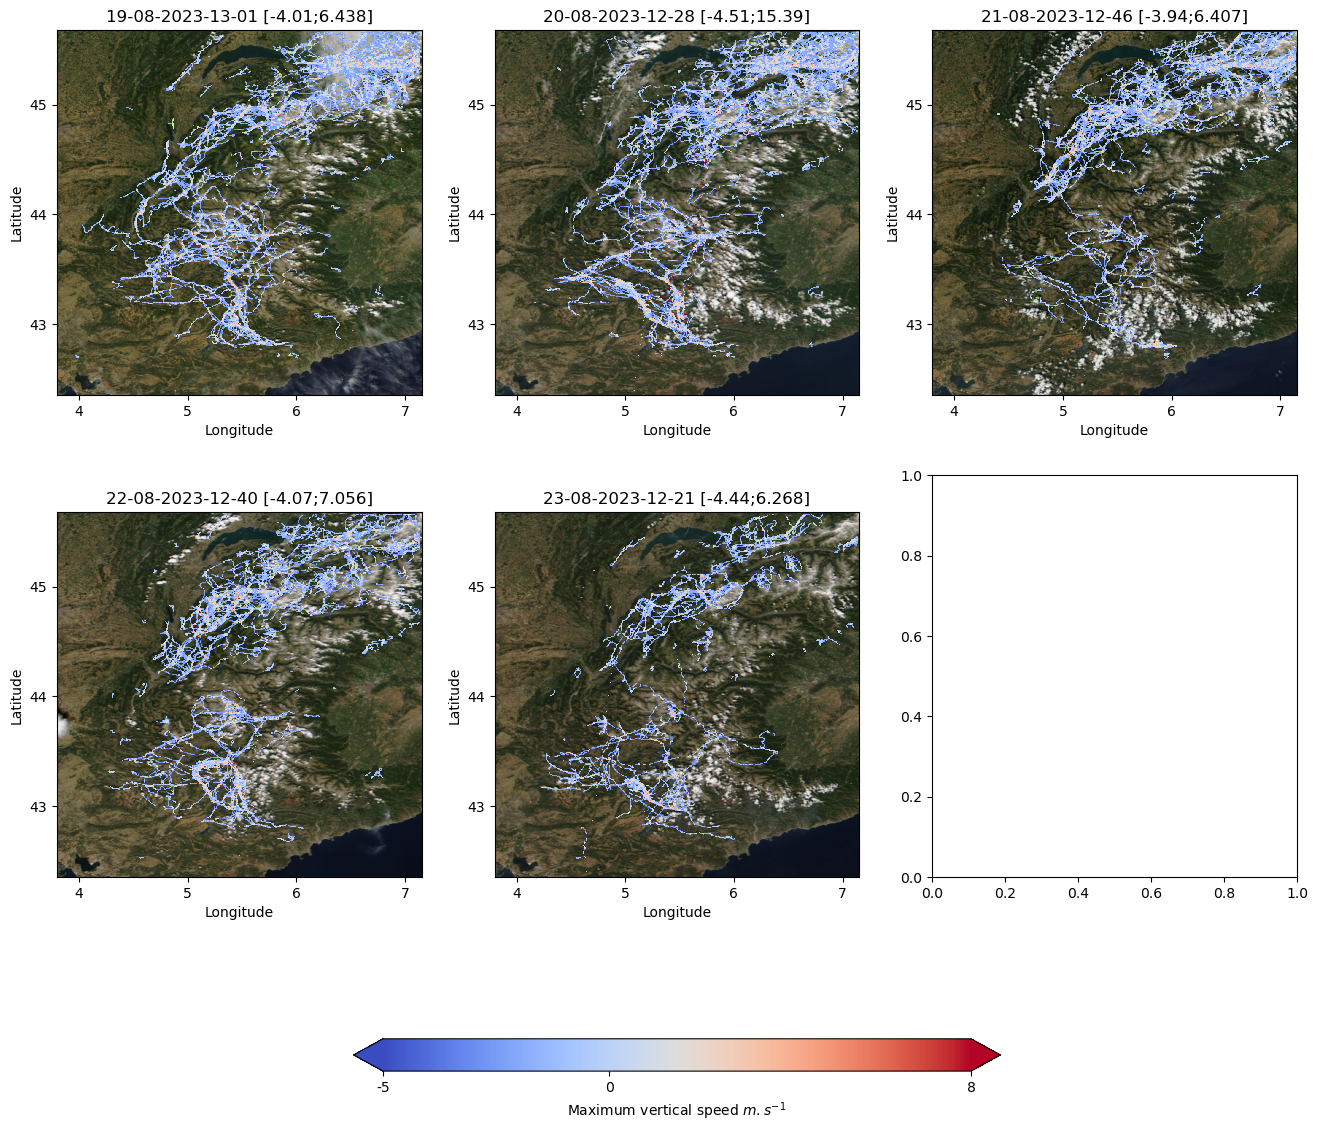

In [10]:
img_extent = (4.7942, 8.1545, 43.3545, 46.6707)
type_vols = ['para','plan']
save_title = 'T:/C2H/STAGES/LEO_BARROIS/figures/max_speed_map_para.png'
vmin,vmax = -5,8

plot_max_speed(img_extent,type_vols[0],save_title,vmin,vmax)

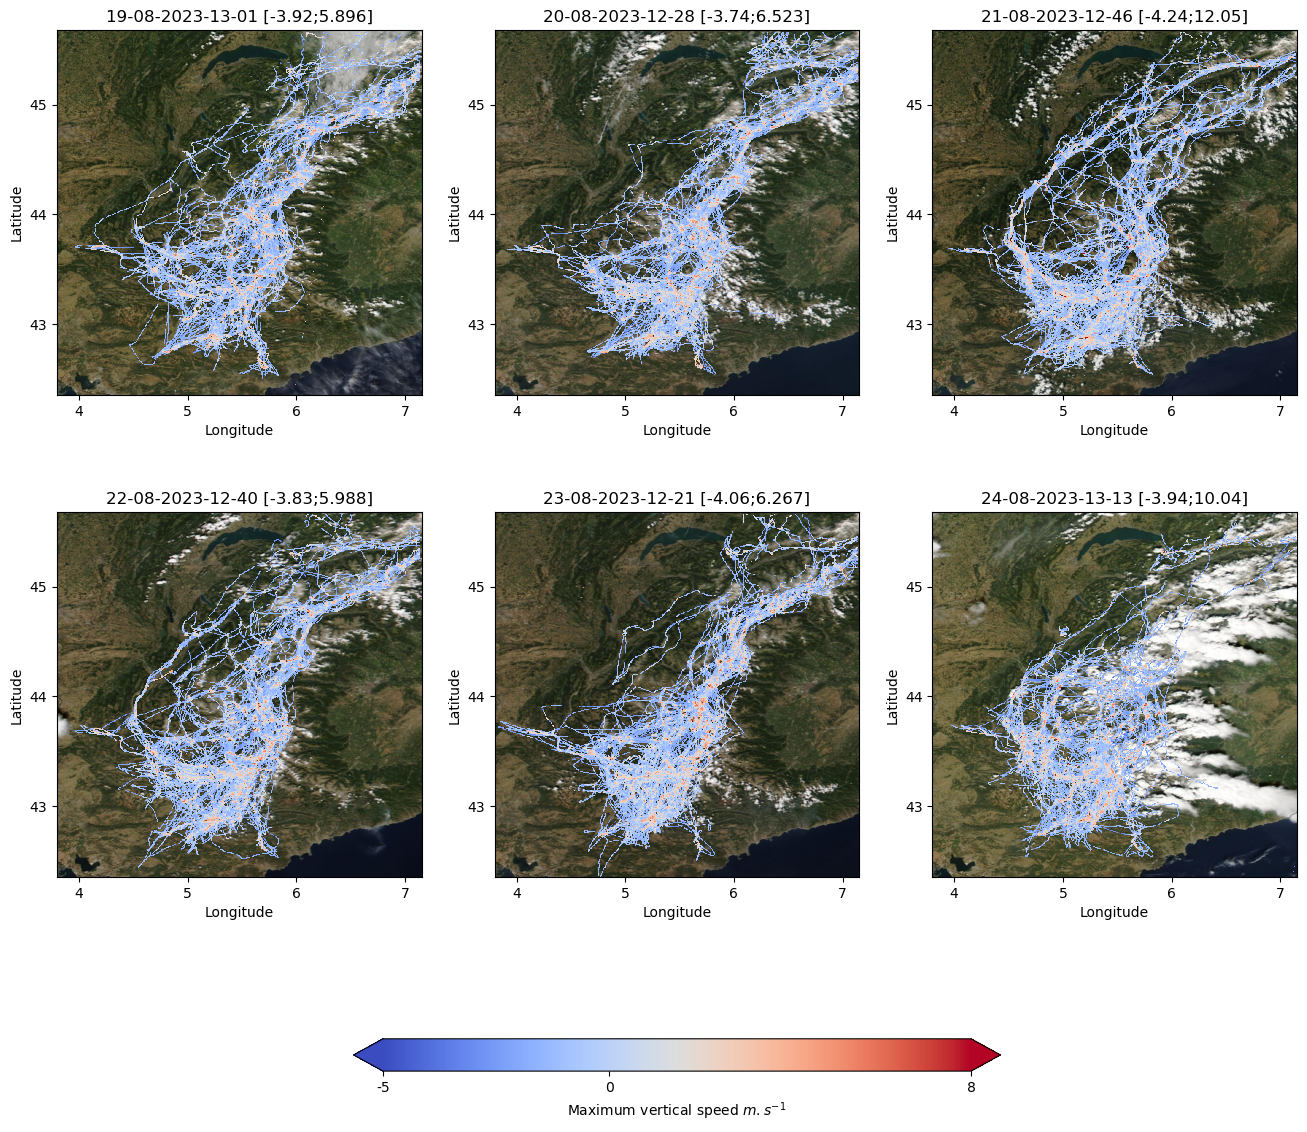

In [16]:
img_extent = (4.7942, 8.1545, 43.3545, 46.6707)
type_vols = ['para','plan']
save_title = 'T:/C2H/STAGES/LEO_BARROIS/figures/max_speed_map_para_2.0.png'
vmin,vmax = -5,8

plot_max_speed(img_extent,type_vols[1],save_title,vmin,vmax)

In [14]:
def plot_dist_speed(type_vol):
    ndarray_save_path = 'T:/C2H/STAGES/LEO_BARROIS/ndarray/maximum_speed_map/'
    type_vols = ['Parapente/','Planeur/']
    days = ['IGC_19-08-2023/','IGC_20-08-2023/','IGC_21-08-2023/','IGC_22-08-2023/','IGC_23-08-2023/','IGC_24-08-2023/']
    titres = ["19-08-2023-13-01","20-08-2023-12-28","21-08-2023-12-46","22-08-2023-12-40","23-08-2023-12-21","24-08-2023-13-13"]
    
    fig,axs = plt.subplots(nrows=2,ncols=3,figsize=(16, 14))
    a = [-1.1 for i in range(1300)]
    
    for i in range(6):
        if i != 5 :
            ax = axs[i//3,i%3]
            
            values_para = np.ravel(np.load('T:/C2H/STAGES/LEO_BARROIS/ndarray/maximum_speed_map/'+days[i]+'Parapente.npy'))
    
            liste_para = [val for val in values_para if val != -9999]
            threshold_para = np.percentile(liste_para, 99.5)
            threshold2_para = np.percentile(liste_para, 0.5)
            liste_para = [val for val in liste_para if threshold2_para < val < threshold_para]
            
            ax.hist(liste_para, bins=100, linewidth=0.5, alpha = 0.3, color = 'b',edgecolor="white")
    
            values_plan = np.ravel(np.load('T:/C2H/STAGES/LEO_BARROIS/ndarray/maximum_speed_map/'+days[i]+'Planeur.npy'))
    
            liste_plan = [val for val in values_plan if val != -9999]
            threshold_plan = np.percentile(liste_plan, 99.5)
            threshold2_plan = np.percentile(liste_plan, 0.5)
            liste_plan = [val for val in liste_plan if threshold2_plan < val < threshold_plan]
            ax.hist(liste_plan, bins=100, linewidth=0.5, alpha = 0.3, color = 'r',edgecolor="white")
            ax.set_xlabel('Wind speed $m.s^{-1}$')
            ax.set_title('Para : [' +str(np.min(liste_para))[:5]+';' +str(np.max(liste_para))[:4] +'] Plan : [' + str(np.min(liste_plan))[:5]+';' +str(np.max(liste_plan))[:4]+']')

                          
        else :
            ax = axs[i//3,i%3]
            values_plan = np.ravel(np.load('T:/C2H/STAGES/LEO_BARROIS/ndarray/maximum_speed_map/'+days[i]+'Planeur.npy'))
    
            liste_plan = [val for val in values_plan if val != -9999]
            threshold_plan = np.percentile(liste_plan, 99.5)
            threshold2_plan = np.percentile(liste_plan, 0.5)
            liste_plan = [val for val in liste_plan if threshold2_plan < val < threshold_plan]
            ax.hist([-100], bins=1, linewidth=0.5, alpha = 0.3, color = 'b',edgecolor="white",label ='Parapente')
            ax.hist([-100], bins=1, linewidth=0.5, alpha = 0.3, color = 'r',edgecolor="white",label ='Parapente')
            ax.hist(liste_plan, bins=100, linewidth=0.5, alpha = 0.3, color = 'r',edgecolor="white")
            ax.set(xlim=(-7, 7))
            ax.set_xlabel('Wind speed $m.s^{-1}$')
            ax.set_title('Plan : [' + str(np.min(liste_plan))[:5]+';' +str(np.max(liste_plan))[:4]+']')

    plt.savefig('T:/C2H/STAGES/LEO_BARROIS/figures/max_speed_map_dist.png')
    fig.suptitle('First order wind speed distribution',fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.show()

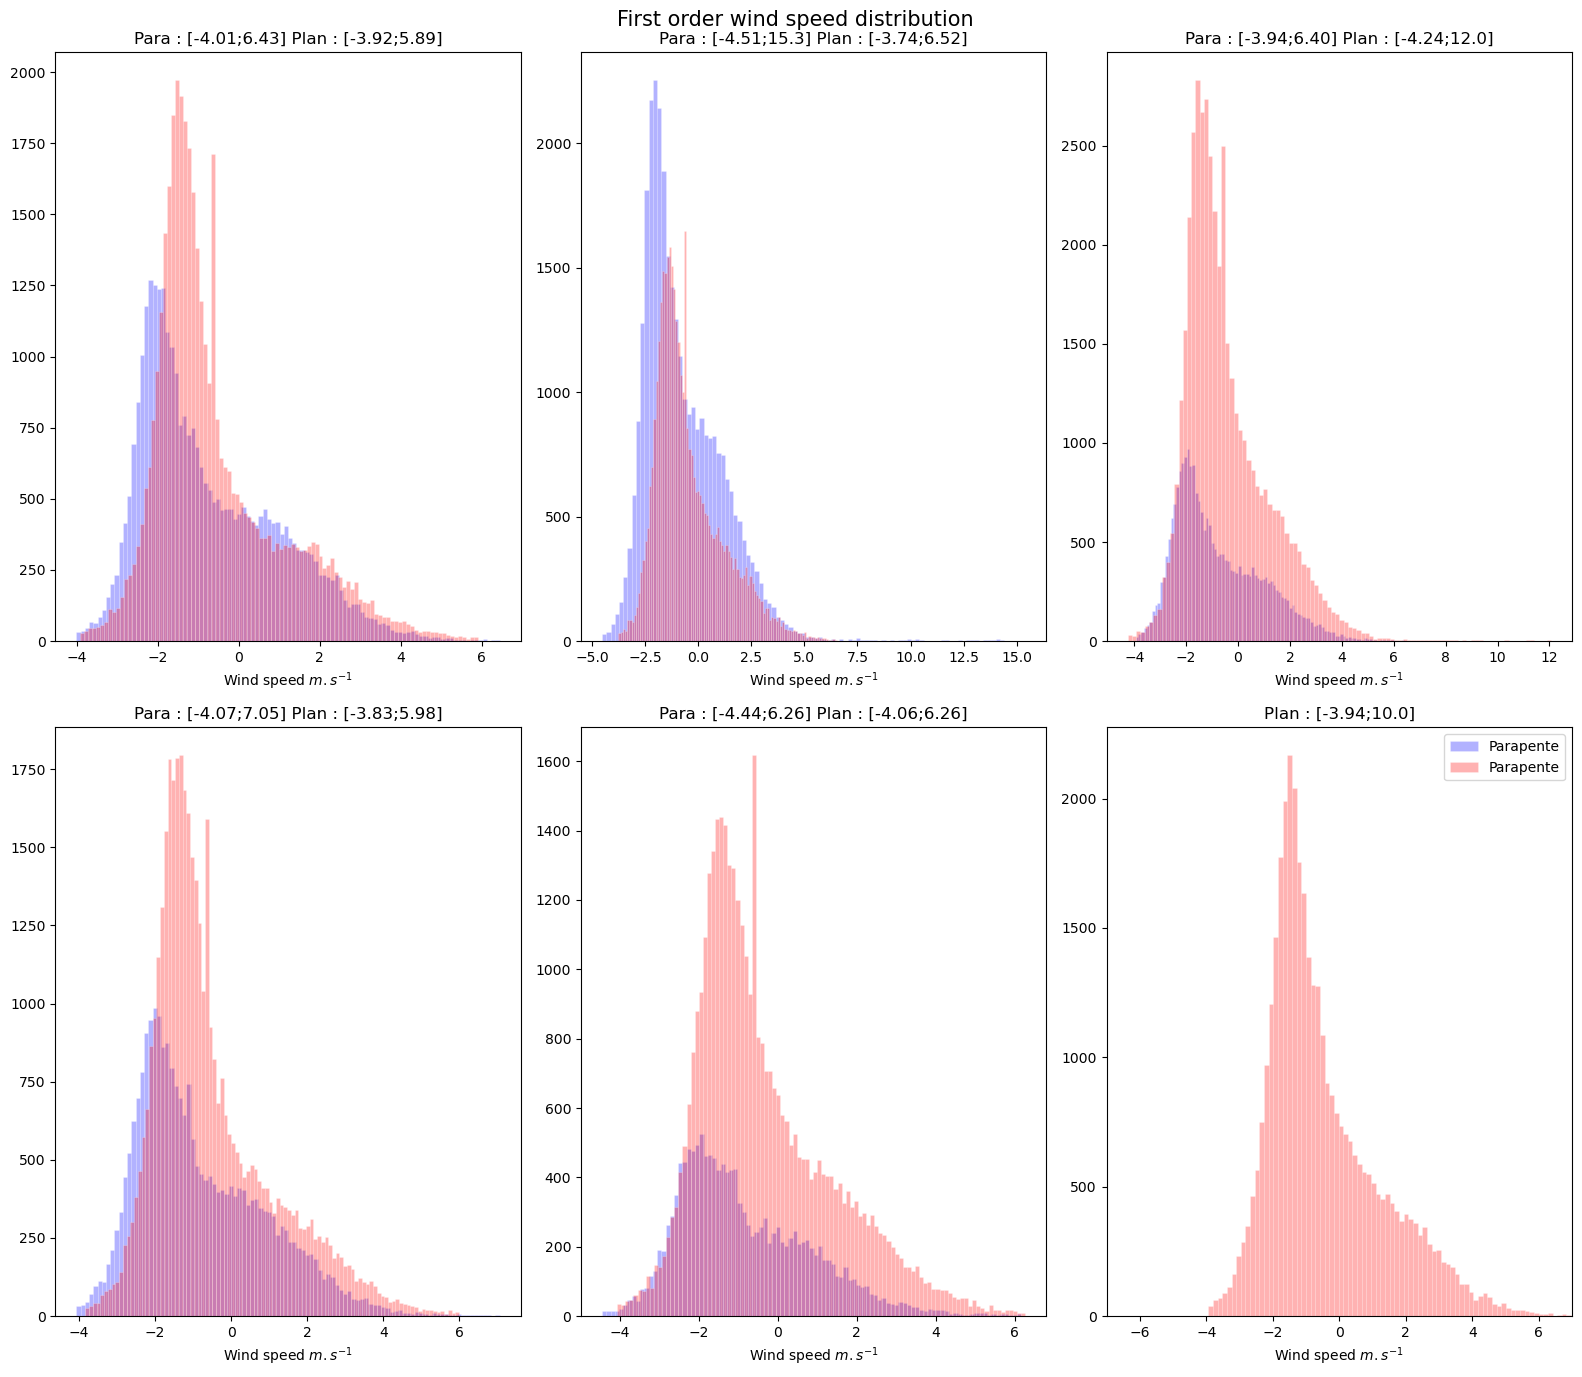

In [15]:
type_vols = ['para','plan']

plot_dist_speed(type_vols[1])